1a.


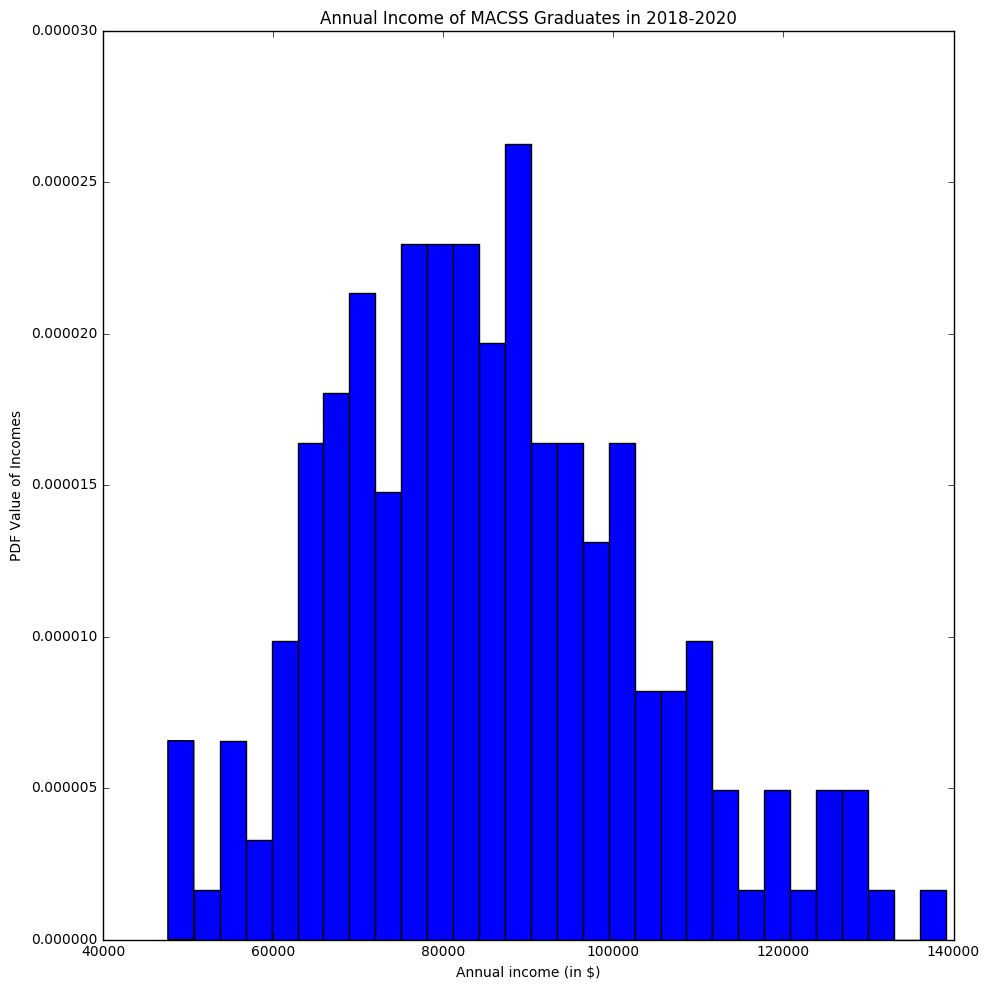

1b.
Using ln_pdf, the test matrix is: [[ 0.0019079   0.00123533]
 [ 0.00217547  0.0019646 ]]
1c.
The estimators mu_SMM1 is: 11.330637236
The estimators sig_SMM1 is: 0.209229370701
Data mean of incomes = 85276.8236063 Data standard deviation of incomes = 17992.542128
Model mean 1 = 85276.8280721 Model standard deviation 1 = 17992.543083
The value of criterion function at the estimated parameter values is: 5.55965986744e-15



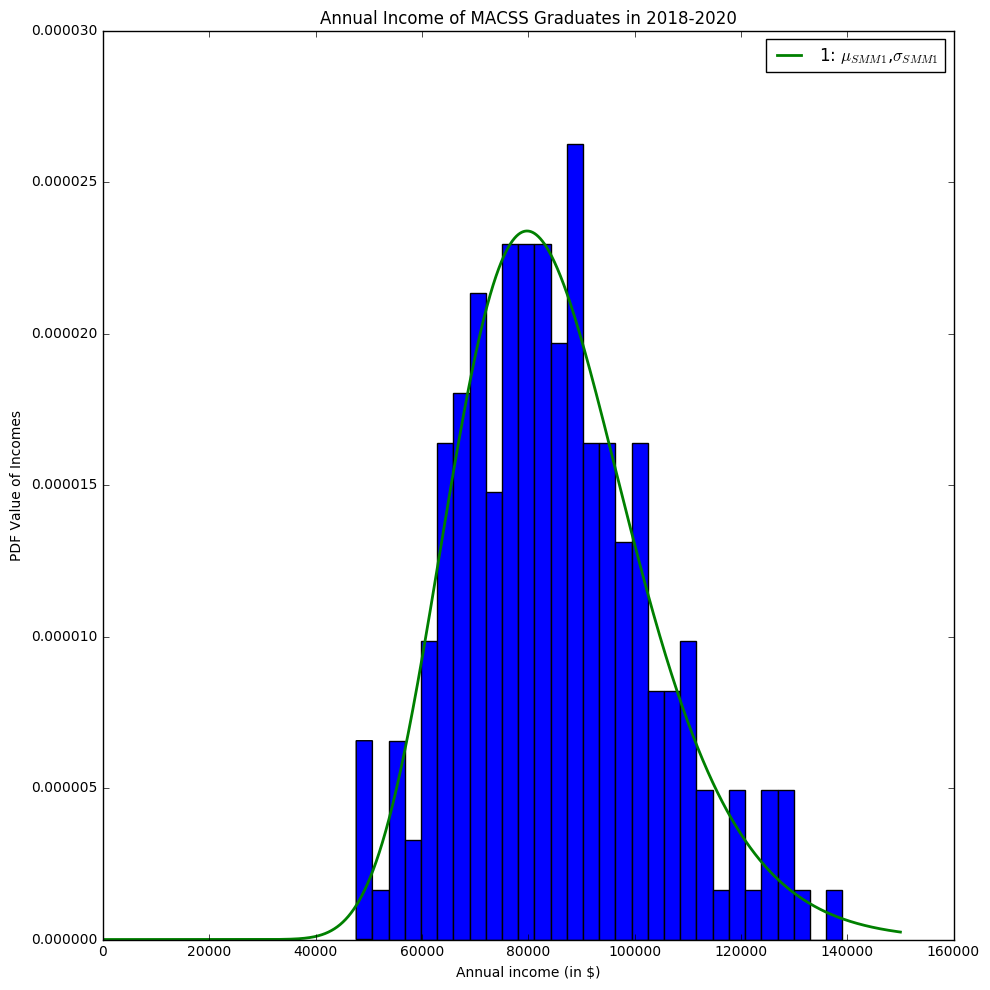

1d.
The estimators mu_SMM2 is: 11.3306372141
The estimators sig_SMM2 is: 0.209229359136
Data mean of incomes = 85276.8236063 Data standard deviation of incomes = 17992.542128
Model mean 2 = 85276.8259939 Model standard deviation 2 = 17992.5416292
The value of criterion function at the estimated parameter values is: 0.000176850368141


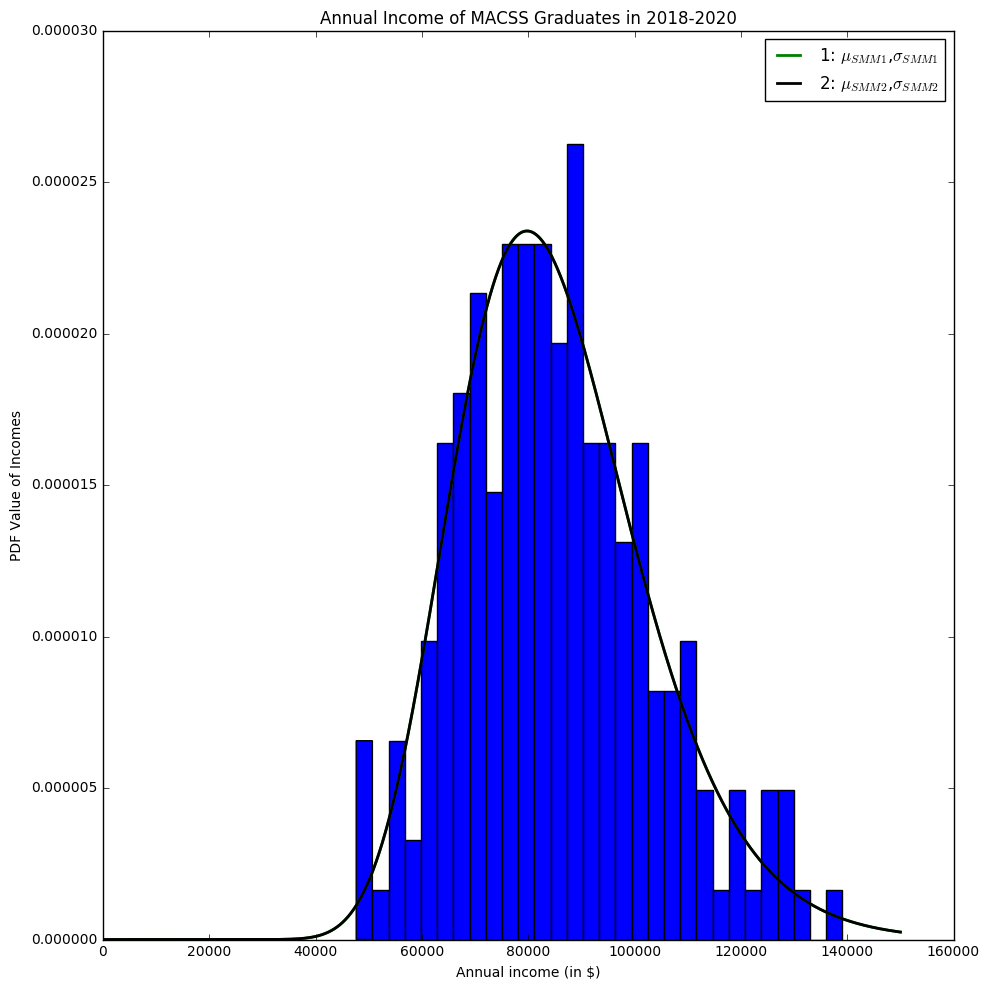

<function matplotlib.pyplot.close>

In [34]:
import numpy as np
import numpy.random as rnd
import numpy.linalg as lin
import scipy.stats as sts
import scipy.integrate as intgr
import scipy.optimize as opt
import matplotlib
import matplotlib.pyplot as plt
import os

np.random.seed(seed=1234)
incomes = np.loadtxt('incomes.txt')

#1a
print('1a.')
graph = True
...
if graph:
    
    # Create directory if images directory does not already exist
    cur_path = os.path.split(os.path.abspath("__file__"))[0]
    output_fldr = "images for Persp_Model PS4"
    output_dir = os.path.join(cur_path, output_fldr)
    if not os.access(output_dir, os.F_OK):
        os.makedirs(output_dir)

    # Plotting histogram of percentages
    fig = plt.figure(figsize = (10,10))
    count, bins, ignored = plt.hist(incomes, 30, normed = True)   
    plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize = 12)
    plt.xlabel(r'Annual income (in $)')
    plt.ylabel(r'PDF Value of Incomes')
    plt.tight_layout()
    output_path = os.path.join(output_dir, 'Fig_1a')
    plt.savefig(output_path)
    plt.show()
    plt.close()


def ln_pdf(xvals,mu, sigma):
    lognorm_pdf_vals = ((1/(xvals*sigma * np.sqrt(2 * np.pi)) *
                        np.exp( - (np.log(xvals) - mu)**2 / (2 * sigma**2)))) 
    return lognorm_pdf_vals

print('1b.')

xvals = np.array([[200.0, 270.0], [180.0, 195.5]]) 
print('Using ln_pdf, the test matrix is:', ln_pdf(xvals, 5.0, 1.0))


def trunc_norm_draws(unif_vals, mu, sigma, cut_lb, cut_ub):   
    # No cutoffs: truncated normal = normal
    if (cut_lb == None) & (cut_ub == None):
        cut_ub_cdf = 1.0
        cut_lb_cdf = 0.0
    # Lower bound truncation, no upper bound truncation
    elif (cut_lb != None) & (cut_ub == None):
        cut_ub_cdf = 1.0
        cut_lb_cdf = sts.norm.cdf(cut_lb, loc=mu, scale=sigma)
    # Upper bound truncation, no lower bound truncation
    elif (cut_lb == None) & (cut_ub != None):
        cut_ub_cdf = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
        cut_lb_cdf = 0.0
    # Lower bound and upper bound truncation
    elif (cut_lb != None) & (cut_ub != None):
        cut_ub_cdf = sts.norm.cdf(cut_ub, loc=mu, scale=sigma)
        cut_lb_cdf = sts.norm.cdf(cut_lb, loc=mu, scale=sigma)    
    unif2_vals = unif_vals * (cut_ub_cdf - cut_lb_cdf) + cut_lb_cdf
    tnorm_draws = sts.norm.ppf(unif2_vals, loc=mu, scale=sigma)
    draws_1_exp=np.exp(tnorm_draws)
    return draws_1_exp



def data_moments(xvals):    
    if xvals.ndim == 1:
        mean_data = xvals.mean()
        std_data = xvals.std()
    elif xvals.ndim == 2:
        mean_data = xvals.mean(axis=0)
        std_data = xvals.std(axis=0)    
    return mean_data, std_data


def err_vec(data_vals, sim_vals, mu, sigma, cut_lb, cut_ub, simple):
    mean_data, std_data = data_moments(data_vals)
    moms_data = np.array([[mean_data], [std_data]])
    mean_sim, std_sim = data_moments(sim_vals)
    mean_model = mean_sim.mean()
    std_model = std_sim.mean()
    moms_model = np.array([[mean_model], [std_model]])
    if simple:
        err_vec = moms_model - moms_data
    else:
        err_vec = (moms_model - moms_data) / moms_data
    
    return err_vec


def criterion(params, *args):
    mu, sigma = params
    xvals, unif_vals, cut_lb, cut_ub, W_hat = args
    sim_vals = trunc_norm_draws(unif_vals, mu, sigma, cut_lb, cut_ub)
    err = err_vec(xvals, sim_vals, mu, sigma, cut_lb, cut_ub,
                  simple=False)
    crit_val = np.dot(np.dot(err.T, W_hat), err) 
    
    return crit_val

N = 200
S = 300
mu_init = 11.0
sig_init = 0.2
cut_lb = 0.0
cut_up =  1500000
mean_data, std_data = data_moments(incomes)
unif_vals_2 = sts.uniform.rvs(0, 1, size=(N, S))
params_init_1 = np.array([mu_init, sig_init])
W_hat1 = np.eye(2)
smm_args1 = (incomes, unif_vals_2, cut_lb, cut_up, W_hat1)
results1= opt.minimize(criterion, params_init_1, args=(smm_args1), 
                          method='L-BFGS-B',
                          bounds=((1e-10, None), (1e-10, None)))
mu_SMM1, sig_SMM1 = results1.x
sim_vals_1 = trunc_norm_draws(unif_vals_2, mu_SMM1, sig_SMM1, cut_lb, cut_up)
mean_sim_1, std_sim_1 = data_moments(sim_vals_1)
mean_model_1 = mean_sim_1.mean()
std_model_1 = std_sim_1.mean()
params_SMM = np.array([mu_SMM1, sig_SMM1])
value = criterion(params_SMM,*smm_args1)[0][0]

print('1c.')
print('The estimators mu_SMM1 is:',mu_SMM1)
print('The estimators sig_SMM1 is:',sig_SMM1)
print('Data mean of incomes =', mean_data, 'Data standard deviation of incomes =', std_data)
print('Model mean 1 =', mean_model_1, 'Model standard deviation 1 =', std_model_1)
print('The value of criterion function at the estimated parameter values is:',value)
print()

#Plot histogram
fig = plt.figure(figsize = (10,10))
count, bins, ignored = plt.hist(incomes, 30, normed = True)   
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income (in $)')
plt.ylabel(r'PDF Value of Incomes')
plt.tight_layout()
    

# Plot the estimated SMM PDF
dist_pts = np.linspace(0.000001, 150000, 150000)
plt.plot(dist_pts, ln_pdf(dist_pts, mu_SMM1, sig_SMM1),
         linewidth=2, color='green', label='1: $\mu_{SMM1}$,$\sigma_{SMM1}$')
plt.legend(loc='upper right')
output_path = os.path.join(output_dir, 'Fig_1c')
plt.savefig(output_path)
plt.show()
plt.close()


# 1d
err_1 = err_vec(incomes, sim_vals_1, mu_SMM1, sig_SMM1, cut_lb, cut_up,
                False)
VCV2_1 = np.dot(err_1, err_1.T) / incomes.shape[0]
W_hat2_1 = lin.pinv(VCV2_1)  
smm_args2_1 = (incomes, unif_vals_2, cut_lb, cut_up, W_hat2_1)
results2_1 = opt.minimize(criterion, params_SMM, args=(smm_args2_1),
                         method='L-BFGS-B', 
                         bounds=((1e-10, None), (1e-10, None)))
mu_SMM2, sig_SMM2 = results2_1.x

print('1d.')
print('The estimators mu_SMM2 is:',mu_SMM2)
print('The estimators sig_SMM2 is:',sig_SMM2)



sim_vals_2 = trunc_norm_draws(unif_vals_2, mu_SMM2, sig_SMM2, cut_lb, cut_up)
mean_sim_2, std_sim_2 = data_moments(sim_vals_2)
mean_model_2 = mean_sim_2.mean()
std_model_2 = std_sim_2.mean()
print('Data mean of incomes =', mean_data, 'Data standard deviation of incomes =', std_data)
print('Model mean 2 =', mean_model_2, 'Model standard deviation 2 =', std_model_2)
params_SMM_2 = np.array([mu_SMM2, sig_SMM2])
value2 = criterion(params_SMM_2,*smm_args2_1)[0][0]
print('The value of criterion function at the estimated parameter values is:',value2)


# Plot the histogram of the data
fig = plt.figure(figsize = (10,10))
count, bins, ignored = plt.hist(incomes, 30, normed = True)   
plt.title('Annual Income of MACSS Graduates in 2018-2020', fontsize = 12)
plt.xlabel(r'Annual income (in $)')
plt.ylabel(r'PDF Value of Incomes')
plt.tight_layout()

# Plot the estimated SMM PDF

dist_pts = np.linspace(0.000001, 150000, 150000)
plt.plot(dist_pts, ln_pdf(dist_pts, mu_SMM1, sig_SMM1),
         linewidth=2, color='green', label='1: $\mu_{SMM1}$,$\sigma_{SMM1}$')
plt.legend(loc='upper right')


#Plot the estimate SMM PDF using two step estimator
dist_pts = np.linspace(0.000001, 150000, 150000)
plt.plot(dist_pts, ln_pdf(dist_pts, mu_SMM2, sig_SMM2),
         linewidth=2, color='black', label='2: $\mu_{SMM2}$,$\sigma_{SMM2}$')
plt.legend(loc='upper right')
output_path = os.path.join(output_dir, 'Fig_1d')
plt.savefig(output_path)
plt.show()
plt.close
